In [3]:
# -*- coding: utf-8 -*-
"""
Created on 2019-07-31
机器学习实战之PCA源码+我的一些注释+sklearn中PCA模块的简单使用
@author: Tobin
"""

'\nCreated on Jul 31.2019\n机器学习实战之PCA源码+我的一些注释+PCA模块的使用\n@author:Tobin\n'

### 降维技术
#### PCA
数据从原来的坐标系转换到了新的坐标系。第一个新坐标轴选择的方向是原始数据方差最大的方向，第二个坐标轴选择和第一个坐标轴正交且具有最大方差的方向。该过程一直重复，重复次数为原始数据中特征的数目。大部分方差都包含在最前面的几个新坐标轴中。
- 优点：可以找到最重要的多个特征。
- 缺点：可能会损失有用信息。

#### 因子分析
假设数据的生成中有一些观察不到的隐变量，数据是这些隐变量和某些噪声的线性组合。隐变量的数据比观察数据的数目少，可以通过找到隐变量，实现数据的降维。
#### 独立成分分析
假设数据是从N个数据源产生，数据为多个数据源的混合观察结果，这些数据源之间在统计上是相互独立的，而在PCA中只假设数据是不相关的。如果数据源的数目小于观察数据的数目，则可以实现降维。

In [7]:
# 虽然有现成的库，但为了更好的理解PCA的执行过程，我们使用numpy实现PCA
import numpy as np
"""
函数说明：PCA特征维度压缩函数
Parameters:
    dataMat - 数据集数据
    topNfeat - 需要保留的特征维度，即要压缩成的维度数，默认4096
    
Returns:
    lowDDataMat - 压缩后的数据矩阵
    reconMat - 压缩后的数据矩阵反构出原始数据矩阵
    
Modify:
    2019-07-31
"""
def pca(dataMat, topNfeat=4096):
    # 求矩阵每一列的均值
    meanVals = np.mean(dataMat, axis=0)
    # 数据矩阵每一列特征减去该列特征均值
    meanRemoved = dataMat - meanVals
    # rowvar=0，说明列为特征，默认为1，行为特征。
    covMat = np.cov(meanRemoved, rowvar=0)
    # 计算协方差矩阵的特征值及对应的特征向量，均保存在相应的矩阵中
    eigVals, eigVects = np.linalg.eig(np.mat(covMat))
    # sort():对特征值矩阵排序(由小到大)
    # argsort():对特征矩阵进行由小到大排序，返回对应排序后的索引
    eigValInd = np.argsort(eigVals)
    # 从排序后的矩阵最后一个开始自下而上选取最大的N个特征值，返回其对应的索引
    eigValInd = eigValInd[: -(topNfeat+1): -1]
    # 将特征值最大的N个特征值对应索引的特征向量提取出来，组成压缩矩阵
    redEigVects = eigVects[:, eigValInd]
    # 将去除均值后的矩阵*压缩矩阵，转换到新的空间，使维度降低为topNfeat
    lowDDataMat = meanRemoved * redEigVects
    # 利用降维后的矩阵反构出原数据矩阵(用作测试，可跟未压缩的原矩阵比对)
    # 此处用转置和逆的结果一样redEigVects.I
    reconMat = (lowDDataMat * redEigVects.T) + meanVals
    #print(reconMat)
    # 返回压缩后的数据矩阵及该矩阵反构出原始数据矩阵
    return lowDDataMat, reconMat

In [20]:
# 要使用pca函数，我们得有个加载数据集的函数
"""
函数说明：解析文本数据
Parameters:
    filename - 文件名
    delim - 每一行不同特征数据之间的分隔方式，默认是tab键‘\t’
    
Returns:
    j将float型数据值列表转化为矩阵返回
    
Modify:
    2019-07-31
"""
def loadDataSet(filename, delim='\t'):
    fr = open(filename)
    stringArr = [line.strip().split(delim) for line in fr.readlines()]
    # map(function, iterable), 将函数f作用到iterable的每个对象上，python3返回迭代器，python2返回列表。
    datArr = [list(map(float, line)) for line in stringArr]
    return np.mat(datArr)

[[10.37044569 11.23955536]
 [10.55719313 11.54594665]
 [ 9.01323877  9.01282393]
 ...
 [ 9.32502753  9.52436704]
 [ 9.0946364   9.14637075]
 [ 9.16271152  9.2580597 ]]
(1000, 1)


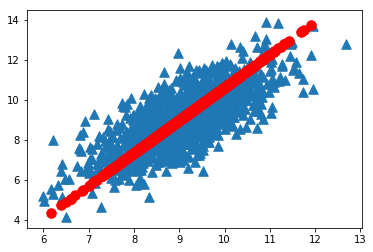

In [29]:
# 验证pca函数在testSet.txt上的作用
import matplotlib.pyplot as plt

dataMat = loadDataSet('testSet.txt')
lowDmat, reconMat = pca(dataMat, topNfeat=1)
print(np.shape(lowDmat))
fig = plt.figure(111)
ax = fig.add_subplot(111)
# 1000*1->1*1000(flatten)->A[0](matrix取数组的第一个元素,只有matrix能使用的方法)
# 红色是重建后的矩阵，蓝色是原始矩阵，因为降成1维，所以恢复不到原来的状态，当pca中topNfeat为2，则恢复数据与原始数据重叠
ax.scatter(dataMat[:, 0].flatten().A[0], dataMat[:, 1].flatten().A[0], marker='^', s=90)
ax.scatter(reconMat[:, 0].flatten().A[0], reconMat[:, 1].flatten().A[0], marker='o', s=90, c='red')

In [92]:
# 利用PCA对半导体制造数据降维,该数据有590维的特征
# 数据中存在很多NaN值，我们使用该特征的均值进行替代
"""
函数说明：缺失值处理函数
Parameters:
    None
    
Returns:
    datMat - 处理后的数据集
    
Modify:
    2019-08-01
"""
def replaceNaNWithMean():
    # 解析数据
    datMat = loadDataSet('secom.data', ' ')
    # 获取特征维度
    numFeat = np.shape(datMat)[1]
    for i in range(numFeat):
        # 利用该维度所有非NaN特征求取均值
        # .A获取矩阵的值，等价于.getA()，matrix转为ndarray格式
        # np.isnan判断是否为np.nan，np.nan是个float类型
        # np.nonzero返回非零值的索引，对所有非零值取个均值
        meanVal = np.mean(datMat[np.nonzero(~np.isnan(datMat[:, 1].A))[0], i])
        # 若均值也是NaN则用0代替
        if (np.isnan(meanVal)):
            meanVal = 0
        # 将该维度中所有NaN特征全部用均值替换
        datMat[np.nonzero(np.isnan(datMat[:, i].A))[0], i] = meanVal
    return datMat


In [90]:
# 补充一个如何判断ndarray中存在空值，每个都看一下不现实，如果存在nan值，那么这一列特征的最小值就是np.nan
datMat = loadDataSet('secom.data', ' ')
for i in range(590):
    print(np.isnan(np.min(datMat[:,i])))


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

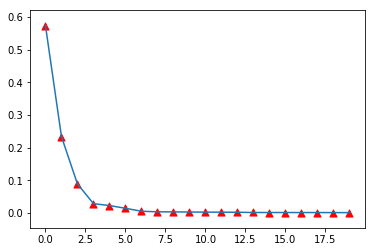

In [104]:
dataMat = replaceNaNWithMean()

fig = plt.figure()
ax = fig.add_subplot(111)

meanVals = np.mean(dataMat, axis=0)
meanRemoved = dataMat - meanVals
covMat = np.cov(meanRemoved, rowvar=0)
eigVals, eigVects = np.linalg.eig(np.mat(covMat))

# 显示前20个特征值的方差百分比，前五个特征96.3%，前20个特征99.3%。
i = 20
ax.scatter(range(i), eigVals[:i]/eigVals.sum(), marker='^', s=50, c='red')
ax.plot(range(i), eigVals[:i]/eigVals.sum())
plt.show()


In [127]:
# 我们自己实现了PCA，因为平时也常会用到PCA模块，记录一下PCA模块的使用
# 输出了前五个特征向量的方差百分比

from sklearn.decomposition import PCA
dataMat = replaceNaNWithMean()
pca = PCA(n_components=5)
dataMat_new = pca.fit_transform(dataMat)
pca.explained_variance_ratio_

array([0.5741083 , 0.23378953, 0.08863362, 0.02841706, 0.02251077])

In [129]:
# 我们比较下PCA模块的输出结果和我们自己计算的结果，是一样的

import warnings
warnings.filterwarnings("ignore")
vr = np.array((list(map(float, [eigVals[i]/eigVals.sum() for i in range(5)]))))
vr

array([0.5741083 , 0.23378953, 0.08863362, 0.02841706, 0.02251077])